In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy_linalg as la
import complex_synapse as cs
import sl_py_tools.matplotlib_tricks as mplt

In [2]:
from sl_py_tools.import_tricks import reload
reload(mplt)

In [34]:
%pdoc plt.box

In [3]:
serial = cs.SynapseMemoryModel.build(cs.builders.build_serial, 12, jmp=0.7)
cascade = cs.SynapseMemoryModel.build(cs.builders.build_cascade, 12, jmp=0.7)

In [4]:
t = la.geomspace(0.1, 1e4, 50)
serial_snr = serial.snr_exp_ave(t)
cascade_snr = cascade.snr_exp_ave(t)

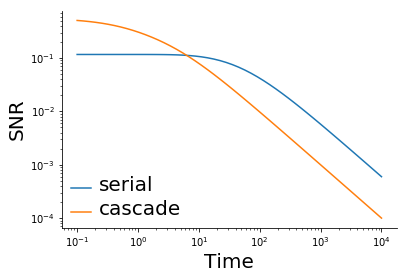

In [5]:
plt.loglog(t, serial_snr, label='serial')
plt.loglog(t, cascade_snr, label='cascade')
ax = plt.gca()
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
lg = ax.legend(loc="lower left")
mplt.clean_axes(ax)